In [1]:
'''
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
%cd ..
'''

# instalar rSim
!apt-get update
!apt-get install qt5-default libode-dev
!cd build
!git clone https://github.com/robocin/rSim.git
%cd rSim
!mkdir buildc
%cd buildc
!ls
!cmake ..
!make -j4
%cd ..
!pip install -e .
%cd ..

# instalar rSoccer
!git clone https://github.com/robocin/rSoccer.git
%cd rSoccer
!pip install -e ./
%cd ..

# instalar a lib ptan
!pip install ptan

# libs de visualização
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

#  **Controle contínuo**

O método A2C é muito fácil de adaptar para problemas de controle contínuo. A alternativa mais simples será uma rede que retorna parâmetros para a distribuições gaussianas. Para $N$ ações, teremos dois vetores de tamanho $N$, onde o primeiro é o vetor das médias e o segundo o vetor das variâncias. Portanto nossa política será um vetor aleatório $N$-dimensional de variáveis aleatórias não-correlacionadas e normalmente distribuidas. 

$
\pi_{\theta}(a|s) = x = [x_1,x_2,...,x_N], x_i \thicksim \mathcal{N}(\mu_i,\sigma_i^2)
$

Por definição:

$
f(x_i|\mu_i,\sigma_i^2) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{-\frac{(x_i-\mu_i)^2}{2\sigma_i^2}}
$

Na forma vetorial: 

$
\pi_{\theta}(a|s) = f(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$

Ao utilizarmos esta fórmula para obter as probabilidades, não há eficiência durante o treinamento (instabilidade numérica), portanto, simplificaremos a expressão para $\log\pi_{\theta}(a|s)$:

$
\log\pi_{\theta}(a|s) = -\frac{(x-\mu)^2}{2\sigma^2} - \log\sqrt{2\pi\sigma^2}
$

Ou seja, após estimar o vetor de médias $\mu$ (rede neural de médias) e o vetor de variâncias $\sigma^2$ (rede neural de variâncias), podemos computar a probabilidade de ocorrência de uma determinada ação $x = [x_1, x_2, ..., x_N]$. Para calcular a **perda da entropia**, que esta associada à uma melhor exploração por parte do agente, utiliza-se a definição de **entropia diferencial** que resulta em:

$
H = \ln\sqrt{2 \pi e \sigma^2}
$


# **Agente** (Rede neural)

*   Output da rede -> 



In [1]:
from torch import nn
import ptan

HID_SIZE = 128

class ModelA2C(nn.Module):
  def __init__(self, obs_size, act_size):
    super(ModelA2C, self).__init__()
    # corpo da rede
    self.base = nn.Sequential(
      nn.Linear(obs_size, HID_SIZE),
      nn.ReLU(),
      nn.Linear(HID_SIZE, HID_SIZE),
      nn.ReLU(),
    )
    # retorna o vetor de médias (Sofplus ajuda a variância a ser positiva)
    self.mu = nn.Sequential(
      nn.Linear(HID_SIZE, HID_SIZE),
      nn.ReLU(),
      nn.Linear(HID_SIZE, act_size),
      nn.Tanh(),
    )
    # retorna o vetor de variâncias
    self.var = nn.Sequential(
      nn.Linear(HID_SIZE, HID_SIZE),
      nn.ReLU(),
      nn.Linear(HID_SIZE, act_size),
      nn.Softplus(),
    )
    # critic -> retorna V(s) (como de costume, esta saída nao possui ativação)
    self.value = nn.Linear(HID_SIZE, 1)

  def forward(self, x):
    base_out = self.base(x)
    return self.mu(base_out), self.var(base_out), self.value(base_out)

  No caso discreto, podemos utilizar as classes **ptan.agent.DQNAgent** ou o **ptan.agent.PolicyAgent**. Porém, no problema contínuo temos que criar nossa própria extensão da classe **ptan.agent.BaseAgent**. A única coisa necessária a se fazer é escrever uma classe derivada de ptan.agent.BaseAgent, e sobrescrever o método __ call __, que precisa converter observações em ações.

In [2]:
class AgentA2C(ptan.agent.BaseAgent):
  def __init__(self, net, device="cpu", lb = -1.0, ub = 1.0):
    self.net = net
    self.device = device
    self.lowerBnd = lb # env.action_space.low 
    self.upperBnd = ub # env.action_space.high
  
  # converter observações em ações
  def __call__(self, states, agent_states):
    # estados
    states_v = ptan.agent.float32_preprocessor(states)
    states_v = states_v.to(self.device)
    # processar médias e variâncias
    mu_v, var_v, _ = self.net(states_v)
    mu = mu_v.data.cpu().numpy()
    sigma = torch.sqrt(var_v).data.cpu().numpy()
    # amostrar ações da distribuição normal N-dimensional
    actions = np.random.normal(mu, sigma)
    # restrição da ação (ação contida entre self.lowerBnd e self.upperBnd)
    # se x < self.lowerBnd, então x = self.lowerBnd
    # se x < self.upperBnd, então x = self.upperBnd
    actions = np.clip(actions, self.lowerBnd, self.upperBnd)
  
    # Apesar do argumento agent_states não ser utilizado, ele ainda sim precisa
    # ser retornado com a ação escolhida, pois a classe BaseAgent suporta
    # a manutenção deste. Vai ficar mais claro com processos OU.
    return actions, agent_states

O processo de treinamento consiste em um loop de treinamento e duas funções:



*  **test_net**: Realiza testes periódicos do nosso modelo em um ambiente de teste separado. Durante este teste, não é necessário fazer nenhuma exploração, apenas utilizar o valor médio retornado pelo modelo (rede que retorna o vetor de médias), sem qualquer amostragem.
*   **calc_logprob**: Calcula o logaritmo das ações escolhidas pela política ($\log\pi_{\theta}(a|s)$)



In [3]:
import math

def test_net(net, env, count=10, device="cpu"):
  rewards = 0.0
  steps = 0
  for _ in range(count):
    obs = env.reset()
    while True:
      obs_v = ptan.agent.float32_preprocessor([obs])
      obs_v = obs_v.to(device)
      mu_v = net(obs_v)[0]
      # perceba que utilizamos o valor retornado pela rede que retorna o vetor de médias
      # da distribuição de ações. Não amostramos com np.random.normal(mu, sigma)
      action = mu_v.squeeze(dim=0).data.cpu().numpy()
      action = np.clip(action, -1, 1)
      obs, reward, done, _ = env.step(action)
      rewards += reward
      steps += 1
      if done:
        break
  return rewards / count, steps / count

def calc_logprob(mu_v, var_v, actions_v):
  # .clamp é utilizada para evitar divisões por zero
  p1 = -((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
  p2 = -torch.log(torch.sqrt(2 * math.pi * var_v))
  return p1 + p2


# **Parâmetros de treinamento**

In [4]:
import time
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim

DEFAULT_ENV_NAME = "SSLPassEndurance-v0"

GAMMA = 0.99
REWARD_STEPS = 2
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
ENTROPY_BETA = 1e-4

TEST_ITERS = 100

#Conversão de dados de treino em tensores

In [5]:
def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v

# Definição do **replay buffer**

Métodos policy gradient fazem parte da classe on-policy e não usam replay buffers (dados das políticas anteriores)

# Loop principal


Algumas considerações sobre objetos da lib ptan.

**ExperienceSource:** retorna pedaços da trajetória em cada iteração. O tamanho destes pedaços é definido pelo parâmetro steps_count. 
* Os pedaços da trajetória são formados por subtrajetóras (que são tuplas $(s,a,r)$). Ou seja, se steps_count = 3, então a cada iteração 3 subtrajetórias serão retornadas.
*  Se steps_count = 1, a cada iteração será retornada uma tupla $(s,a,r)$. Na primeira iteração temos o estado inicial, e na segunda iteração temos o estado resultante da ação tomada na primeira iteração.
*  Se steps_count = 2, a cada iteração será retornado um array contendo duas tuplas $(s,a,r)$. Dependendo do término do episódio, podem ser retornados duas ou uma tupla  $(s,a,r)$


**ExperienceSourceFirstLast:** retorna pedaços da trajetória, porém agora são tuplas $(s,a,r,s')$.

* Os pedaços da trajetória não contêm subtrajetórias, apenas o primeiro estado $s = s_1$ e o último $s' = s_{n+1}$, onde $n = $ *steps_count*, junto com a ação tomada em $s$ e o retorno acumulado $r$ obtido pelo agente do estado inicial $s_1$ até o final $s_{n+1}$





In [6]:
import gym 
import rsoccer_gym
import ptan
import torch.nn.functional as F

env = gym.make(DEFAULT_ENV_NAME)
test_env = gym.make(DEFAULT_ENV_NAME)
device = "cpu"

net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
agent = AgentA2C(net, device=device, lb = env.action_space.low[0], ub = env.action_space.high[0])
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, GAMMA, steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

batch = []
best_reward = None
rewards_ = [] 
steps_ = []
for step_idx, exp in enumerate(exp_source):
  rewards_steps = exp_source.pop_rewards_steps()
  if rewards_steps:
      rewards, steps = zip(*rewards_steps)
      rewards_.append(rewards[0])
      steps_.append(step_idx)

  if step_idx % TEST_ITERS == 0:
      ts = time.time()
      rewards, steps = test_net(net, test_env, device=device)
      print("Test done is %.2f sec, reward %.3f, steps %d, total_steps %d" % (
          time.time() - ts, rewards, steps, step_idx))
      if best_reward is None or best_reward < rewards:
          if best_reward is not None:
              print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
              name = DEFAULT_ENV_NAME + "-A2C.dat"
              torch.save(net.state_dict(), name)
          best_reward = rewards

  batch.append(exp)
  if len(batch) < BATCH_SIZE:
      continue

  # unpack experience batch
  states_v, actions_v, vals_ref_v = unpack_batch_a2c(
          batch, net, device=device,
          last_val_gamma=GAMMA ** REWARD_STEPS)
  batch.clear()

  optimizer.zero_grad()
  # get mu_v, var_v, value_v outputs from net
  mu_v, var_v, value_v = net(states_v)

  # get critic loss
  loss_value_v = F.mse_loss(
      value_v.squeeze(-1), vals_ref_v)

  # get actor loss
  adv_v = vals_ref_v.unsqueeze(dim=-1) - \
          value_v.detach()
  log_prob_v = adv_v * calc_logprob(
      mu_v, var_v, actions_v)
  loss_policy_v = -log_prob_v.mean()

  # get entropy loss
  ent_v = -(torch.log(2*math.pi*var_v) + 1)/2
  entropy_loss_v = ENTROPY_BETA * ent_v.mean()

  # update net parameters
  loss_v = loss_policy_v + entropy_loss_v + loss_value_v
  loss_v.backward()
  optimizer.step()

  if step_idx >= 1e6:
    break


A saída de streaming foi truncada nas últimas 5000 linhas.
Test done is 1.18 sec, reward 0.091, steps 46, total_steps 554600
Test done is 0.88 sec, reward -0.167, steps 33, total_steps 554700
Test done is 1.11 sec, reward 0.122, steps 45, total_steps 554800
Test done is 0.92 sec, reward -0.211, steps 35, total_steps 554900
Test done is 1.01 sec, reward -0.081, steps 40, total_steps 555000
Test done is 0.89 sec, reward -0.210, steps 35, total_steps 555100
Test done is 1.17 sec, reward 0.089, steps 44, total_steps 555200
Test done is 0.83 sec, reward -0.441, steps 31, total_steps 555300
Test done is 0.98 sec, reward -0.176, steps 38, total_steps 555400
Test done is 0.97 sec, reward 0.022, steps 39, total_steps 555500
Test done is 0.97 sec, reward -0.147, steps 38, total_steps 555600
Test done is 0.99 sec, reward -0.034, steps 39, total_steps 555700
Test done is 0.82 sec, reward -0.236, steps 30, total_steps 555800
Test done is 0.81 sec, reward -0.229, steps 31, total_steps 555900
Test do

KeyboardInterrupt: ignored

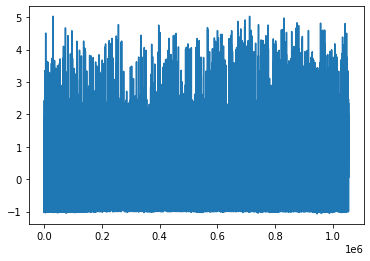

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(steps_,rewards_)

# Agente treinado em ação

In [8]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

Environment initialized



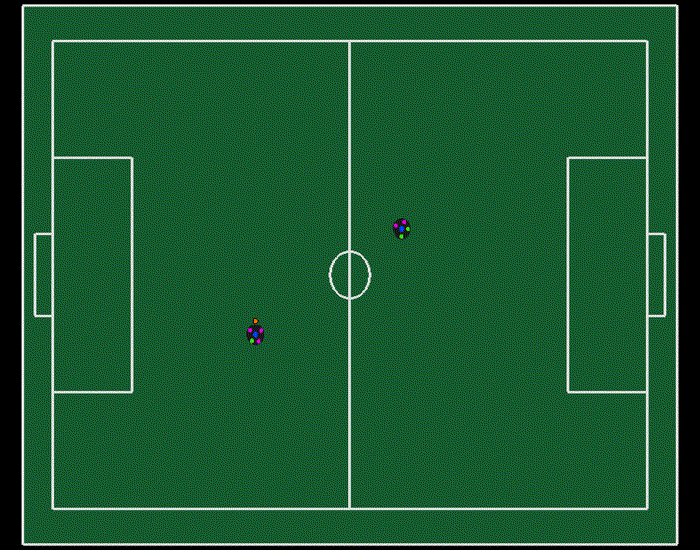

In [9]:
import gym
import ptan

from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

# ambiente
env = gym.make(DEFAULT_ENV_NAME)

# agente
net = ModelA2C(env.observation_space.shape[0],env.action_space.shape[0])
net.load_state_dict(torch.load(DEFAULT_ENV_NAME + "-A2C.dat"))
net.eval()
agent = AgentA2C(net, device=device, lb = env.action_space.low[0], ub = env.action_space.high[0])

# start simulation
for i in range(1):
  done = False
  frames = []
  observation = env.reset()
  while not done:
    obs_v = torch.FloatTensor([observation])
    action, _ = agent(obs_v, [])
    observation, reward, done, info = env.step(action[0]) 
    screen = Image.fromarray(env.render(mode='rgb_array'))
    screen = screen.resize(size=(700, 550))
    frames.append(screen) 

env.close()

frames[0].save('episode.gif', format='GIF',
               append_images=frames[1:], save_all=True, loop = 100, duration =0.0001)

show_gif('episode.gif')

Agente com politica aleatória

Environment initialized



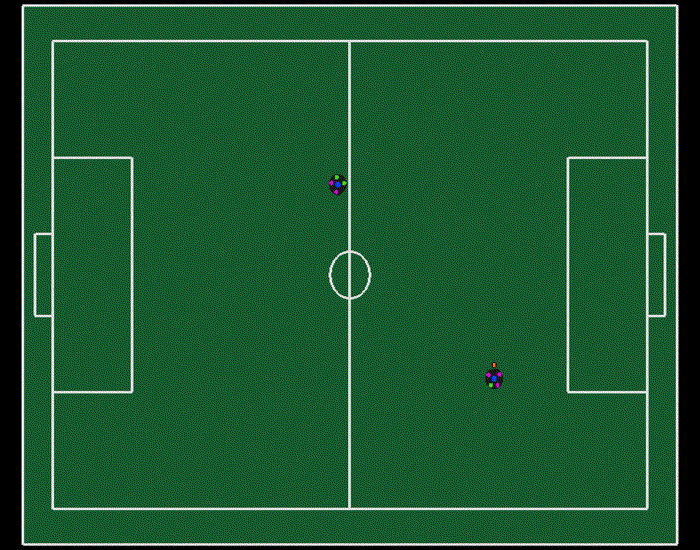

In [11]:
import gym 

from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

env = gym.make(DEFAULT_ENV_NAME)
observation = env.reset()
for i in range(1):
  done = False
  frames = []
  while not done:
    #env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)   
    screen = Image.fromarray(env.render(mode='rgb_array'))
    screen = screen.resize(size=(700, 550))
    frames.append(screen)   
    #if done:
    #    observation = env.reset() 

env.close()
frames[0].save('episode.gif', format='GIF',
               append_images=frames[1:], save_all=True, loop = 100, duration =0.0001)

show_gif('episode.gif')